# Case Study 4 - Augmentation

In this case study we will be augmenting a small dataset using the concept of domain adaptation. For this we will be using a RadialGAN as discussed in [this paper](https://arxiv.org/pdf/1802.06403.pdf).

***Idea***: How about we have big models saved to show, but we run small `n_iter` values in the session. Check small models to see if required/worth it. **Small n_iter seems fine?**
## Imports
Lets import the required standard libraries and relevant Synthcity modules. We can also set the level of logging here. 

In [3]:
# stdlib
import warnings
from pathlib import Path

# 3rd Party
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score
import xgboost as xgb
import seaborn as sns
# from tqdm import tqdm

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.utils import serialization

warnings.filterwarnings("ignore")
# Set the level for the logging
# log.add(sink=sys.stderr, level="DEBUG")
log.remove()

# The Scenario

Brazil is divided geopolitically into five macroregions: north, northeast, central-west, southeast, and south. For this case study, we will be acting as government officials in the Central-West Region of Brazil. Central-West Brazil is the smallest region in the country by population. It is also one of the largest and most rural regions. This means the number of COVID-19 patient records is significantly smaller compared to the larger regions.

<img src="../data/Brazil_COVID/Brazil_Labelled_Map.png" alt="Brazil Region Map" width="400"/>

COVID-19 hit different regions at different time. Cases peaked later in the Central-West than in the more densely-populated and well-connected regions. Giving us the problem of scarce data in terms of COVID-19 patients in the region, but the potential lifeline of having larger datasets from the other regions, which we can learn from in order to augment our dataset. We cannot simply train our model on the data from all regions, because there is significant co-variate shift between the different regions and so we will achieve a better classifier by training on solely Central-West data, even if it is synthetic. 

### Load the data
Lets set it up as a classification task with a death at time horizon column.  

In [4]:
X = pd.read_csv(f"../data/Brazil_COVID/covid_normalised_numericalised_classification.csv")
X.drop(columns=["is_dead", "Days_hospital_to_outcome"], inplace=True) # drop survival columns to frame it as a classification problem

# Define the mappings from region index to region
region_mapper = {
    0: "Central-West",
    1: "North",
    2: "Northeast",
    3: "South",
    4: "Southeast",
}
our_region_index = 0
print(X["Region"].value_counts().rename(region_mapper))

X_our_region_only = X.loc[X["Region"] == our_region_index].copy()
X_other_regions = X.loc[X["Region"] != our_region_index].copy()

display(X_our_region_only)


Southeast       4929
Northeast        714
South            624
North            510
Central-West     105
Name: Region, dtype: int64


,is_dead_at_time_horizon=14,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,...,Vomitting,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal
32,0,37,1,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
33,0,62,1,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
42,0,56,1,1,0,1,1,0,1,1,...,1,0,0,0,0,0,0,0,0,0
44,0,25,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
45,0,27,1,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6818,0,58,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6819,0,63,0,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
6820,0,30,1,1,0,1,1,0,1,1,...,1,0,0,0,0,0,0,0,0,0
6821,0,38,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# The problem

Lets train a model on just our data from the Northern region.

In [6]:
y = X_our_region_only["is_dead_at_time_horizon=14"]
X_in = X_our_region_only.drop(columns=["is_dead_at_time_horizon=14"])

X_train, X_test, y_train, y_test = train_test_split(X_in, y, random_state=4)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Train model on whole dataset
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8, 
    colsample_bytree=1, 
    gamma=1, 
    objective="binary:logistic",
    random_state=42,
)
xgb_model.fit(X_train, y_train)

calculated_accuracy_score_train = accuracy_score(y_train, xgb_model.predict(X_train))
y_pred = xgb_model.predict(X_test)
calculated_accuracy_score_test = accuracy_score(y_test, y_pred)
print(f"Evaluating accuracy: train set: {calculated_accuracy_score_train} | test set: {calculated_accuracy_score_test}")


Evaluating accuracy: train set: 0.9102564102564102| test set: 0.7407407407407407


As you can see we are significantly overfitting due to the very small dataset.

### Now lets test our assertion that we can't just use all the training data and apply it to our region
As you can see our accuracy does significantly improve, but we can do better! And there will be cases where there is a greater co-variate shift that impacts this accuracy to a much greater extent.

In [7]:
y = X["is_dead_at_time_horizon=14"]
X_in = X.drop(columns=["is_dead_at_time_horizon=14"])

X_train, _, y_train, _ = train_test_split(X_in, y, random_state=4)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

y = X_our_region_only["is_dead_at_time_horizon=14"]
X_in = X_our_region_only.drop(columns=["is_dead_at_time_horizon=14"])

_, X_test, _, y_test = train_test_split(X_in, y, random_state=4)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Train model on whole dataset
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8, 
    colsample_bytree=1, 
    gamma=1, 
    objective="binary:logistic",
    random_state=42,
)
xgb_model.fit(X_train, y_train)

calculated_accuracy_score_train = accuracy_score(y_train, xgb_model.predict(X_train))
y_pred = xgb_model.predict(X_test)
calculated_accuracy_score_test = accuracy_score(y_test, y_pred)
print(f"Evaluating accuracy: train set: {calculated_accuracy_score_train} | test set: {calculated_accuracy_score_test}")

Evaluating accuracy: train set: 0.8126332106180972| test set: 0.9259259259259259


# The Solution

Load the superset of data from all regions into the GerericDataLoader object.

In [8]:
loader = GenericDataLoader(
    X, # X is the dataframe which is a superset of all region data
    target_column="is_dead_at_time_horizon=14", # The column containing the labels to predict
    sensitive_features=["Age", "Sex", "Ethnicity", "Region"], # The sensitive features in the dataset (Not needed here?)
    domain_column="Region", # This labels the domain that each record is from. Where it is `1` it is from our small dataset.
    random_state=42,
)


In [9]:
outdir = Path("saved_models")
prefix = "Augmentation"
model="radialgan"
n_iter = 10

print(model)

save_file = outdir / f"{prefix}.{model}_numericalised_{region_mapper[our_region_index]}_n_iter={n_iter}.bkp"
if Path(save_file).exists():
    syn_model = serialization.load_from_file(save_file)
else:
    syn_model = Plugins().get(model, n_iter=n_iter)
    syn_model.fit(loader)
    syn_model.generate(count=6882).dataframe()
    serialization.save_to_file(save_file, syn_model)


radialgan


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]


Train a model on the generated data

Also check a model trained on the whole dataset tested on the northern data to see if we can make that point too...

In [10]:
accuracies = []
generated_records = [
    1,2,3,4,5,6,7,8,9,10,
    20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,8000,10000,20000
]
for n_gen_records in generated_records:
    synth_data = syn_model.generate(n_gen_records, domains=[our_region_index])

    # Now we can augment our original dataset with our new synthetic data
    augmented_data = pd.concat([
        synth_data.dataframe(),
        X_our_region_only,
    ])

    augmented_y = augmented_data["is_dead_at_time_horizon=14"]
    augmented_X_in = augmented_data.drop(columns=["is_dead_at_time_horizon=14"])

    X_train, X_test, y_train, y_test = train_test_split(augmented_X_in, augmented_y, random_state=4)
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    # Train model on whole dataset
    xgb_model = xgb.XGBClassifier(
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.8, 
        colsample_bytree=1, 
        gamma=1, 
        objective="binary:logistic",
        random_state=42,
    )
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    calculated_accuracy_score_train = accuracy_score(y_train, xgb_model.predict(X_train))
    calculated_accuracy_score_test = accuracy_score(y_test, y_pred)
    print(f"Evaluating accuracy: n_gen_records: {n_gen_records} train set: {calculated_accuracy_score_train}| test set: {calculated_accuracy_score_test}")
    accuracies.append(calculated_accuracy_score_test)

Evaluating accuracy: n_gen_records: 1 train set: 0.9113924050632911| test set: 0.7777777777777778
Evaluating accuracy: n_gen_records: 2 train set: 0.9375| test set: 0.7407407407407407
Evaluating accuracy: n_gen_records: 3 train set: 0.9382716049382716| test set: 0.7777777777777778
Evaluating accuracy: n_gen_records: 4 train set: 0.9259259259259259| test set: 0.7857142857142857
Evaluating accuracy: n_gen_records: 5 train set: 0.9390243902439024| test set: 0.75
Evaluating accuracy: n_gen_records: 6 train set: 0.891566265060241| test set: 0.8928571428571429
Evaluating accuracy: n_gen_records: 7 train set: 0.9285714285714286| test set: 0.8214285714285714
Evaluating accuracy: n_gen_records: 8 train set: 0.9404761904761905| test set: 0.7931034482758621
Evaluating accuracy: n_gen_records: 9 train set: 0.9411764705882353| test set: 0.7586206896551724
Evaluating accuracy: n_gen_records: 10 train set: 0.9302325581395349| test set: 0.7931034482758621
Evaluating accuracy: n_gen_records: 20 train s

[(1, 0.7777777777777778), (2, 0.7407407407407407), (3, 0.7777777777777778), (4, 0.7857142857142857), (5, 0.75), (6, 0.8928571428571429), (7, 0.8214285714285714), (8, 0.7931034482758621), (9, 0.7586206896551724), (10, 0.7931034482758621), (20, 0.71875), (30, 0.8529411764705882), (40, 0.8108108108108109), (50, 0.9230769230769231), (60, 0.8333333333333334), (70, 0.8409090909090909), (80, 0.8936170212765957), (90, 0.8367346938775511), (100, 0.8269230769230769), (200, 0.8961038961038961), (300, 0.8529411764705882), (400, 0.905511811023622), (500, 0.9276315789473685), (600, 0.9152542372881356), (700, 0.8811881188118812), (800, 0.9074889867841409), (900, 0.9365079365079365), (1000, 0.9133574007220217), (2000, 0.9354838709677419), (3000, 0.9305019305019305), (4000, 0.9201557935735151), (5000, 0.9373531714956931), (8000, 0.9304390725209669), (10000, 0.9208547685001979), (20000, 0.9172468669186393)]


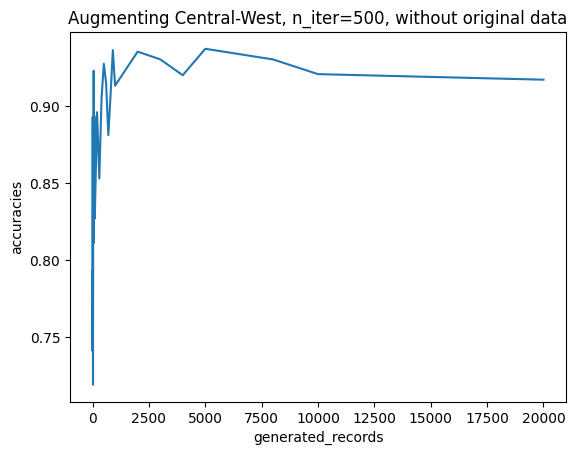

In [12]:
print(list(zip(generated_records, accuracies)))
d = {"generated_records": generated_records, "accuracies": accuracies}
accuracy_data= pd.DataFrame(d)
plot = sns.lineplot(y="accuracies", x="generated_records", data=accuracy_data).set(title=f"Augmenting {region_mapper[our_region_index]}, n_iter={500}, without {'original data'}")
